* Download dependecies section

In [1]:
!pip install --upgrade --quiet pip
!pip install --quiet transformers datasets accelerate deepspeed pymorphy2 peft trl==0.7.4

* Import section

In [2]:
import pandas as pd
import seaborn as sns
import re
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, XLMRobertaModel, XLMRobertaConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from peft import LoraConfig
from trl import SFTTrainer
from gensim.models import KeyedVectors

2024-03-20 07:07:48.441875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 07:07:48.442007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 07:07:48.566062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2024-03-20 07:07:58,176] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


* Importing data

In [3]:
data = pd.read_excel('/kaggle/input/dataset5/Feedback_data.xlsx', index_col=0)
data

,id,text,class
0,45,негатив к вам и горячей линии которые нафиг н...,Консультация КЦ
1,97,перестаньте впаривать клиентам дополнительные ...,Компетентность продавцов/ консультантов
2,105,продавец предложил наклеить защитную плёнку з...,Компетентность продавцов/ консультантов
3,127,продавец режил продать нам товар почему то по ...,Компетентность продавцов/ консультантов
4,130,навязанные услуги ( без моего согласия) на сум...,Компетентность продавцов/ консультантов
...,...,...,...
2832,17570,почему отключили электронную очередь через пол...,Электронная очередь
2833,17579,очередь на кассе. продавцы не торопятся с зака...,Время ожидания у кассы
2834,17586,"профессионализма менеджеру бы, да и внимания к...",Обслуживание продавцами/ консультантами
2835,17591,сотрудник на выдаче заказа потребовал документ...,Электронная очередь


In [4]:
# Converting to numpy
X = data['text'].to_numpy()
Y = data['class'].to_numpy()

* Exploration analysis

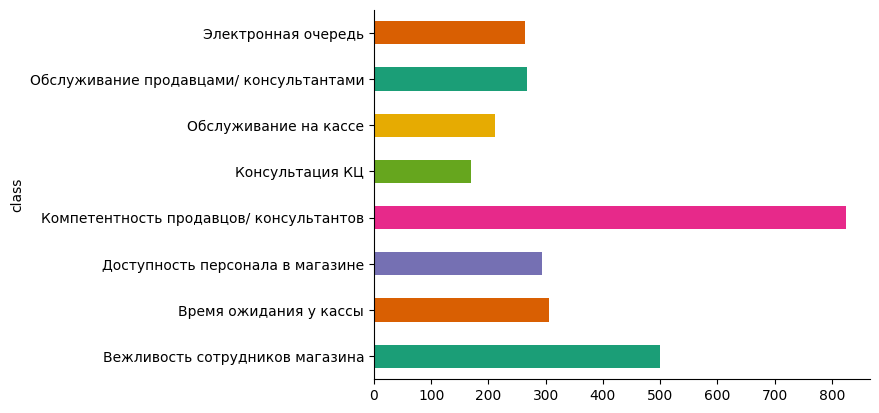

In [5]:
# We can see that there is a slight class imbalance in data, I think that this is not a crucial
# May be we need to adjust an addition weight while training

data.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
# Assert that all id's are unique and there are no missing values

assert data['id'].value_counts().sum() == data.shape[0]
data.isnull().sum()

id       0
text     0
class    0
dtype: int64

* Data Preparation

In [7]:
# Let's prepare data for tokenization

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
morph = MorphAnalyzer()

label2ind = {label: i for i, label in enumerate(data['class'].unique())}
ind2label = {v: k for k, v in label2ind.items()}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, label2ind, tokenizer=None):
        super(Dataset).__init__()
        self.texts = x
        self.labels = y
        self.label2ind = label2ind
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        output = self.prepare_example(self.texts[index])
        output['label'] = label2ind[self.labels[index]]
        return output

    def prepare_example(self, text):
        text = re.sub(patterns, ' ', text)
        tokens = []
        for token in text.split():
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
        return self.tokenizer(' '.join(tokens))

* Baseline: we will use roberta trained on russian texts

In [8]:
model_name = 'blinoff/roberta-base-russian-v0'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)
tokenizer = AutoTokenizer.from_pretrained(model_name)

for (name, module) in model.roberta.named_modules():
    for parameter in module.parameters():
        parameter.requires_grad = False

model

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/500M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at blinoff/roberta-base-russian-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50021, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [9]:
# Splitting data into train and val sets
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=52, stratify=Y)

In [10]:
# Creating Datasets
trainDataset = Dataset(x_train, y_train, label2ind, tokenizer)
valDataset = Dataset(x_val, y_val, label2ind, tokenizer)

* Define Baseline Trainer

In [11]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Calculate recall for each class
    recalls = recall_score(labels, preds, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7]) # Adjust labels based on your classes

    # Create a dictionary to store recall for each class
    results = {}
    for i, recall in enumerate(recalls):
        results[f'class_{i}_recall'] = recall
    
    f1 = f1_score(labels, preds, average='macro')
    results['F1'] = f1

    return results



# Setting congifurations for LORA PEFT
peft_config = LoraConfig(
    lora_alpha=8,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules = ["query", "key", "value", "dense"],
    task_type="SEQ_CLS",
)

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=50,
    per_device_train_batch_size=16,
    save_strategy='no',
    evaluation_strategy="epoch"
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=trainDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    peft_config=peft_config,
    dataset_text_field='text'
)

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 512
  warnings.warn(


In [29]:
# We can see that the best F1 score is 0.77. Let's upgrade it further
trainer.train()

Epoch,Training Loss,Validation Loss,Class 0 Recall,Class 1 Recall,Class 2 Recall,Class 3 Recall,Class 4 Recall,Class 5 Recall,Class 6 Recall,Class 7 Recall,F1
1,No log,1.877343,0.000000,1.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.061722
2,No log,1.769306,0.000000,0.963855,0.000000,0.172414,0.080000,0.000000,0.000000,0.258065,0.152120
3,No log,1.608026,0.000000,0.903614,0.192308,0.620690,0.180000,0.000000,0.037037,0.451613,0.281105
4,No log,1.467999,0.000000,0.939759,0.192308,0.655172,0.140000,0.047619,0.185185,0.612903,0.332800
5,No log,1.344313,0.000000,0.843373,0.653846,0.620690,0.300000,0.047619,0.148148,0.580645,0.378518
6,No log,1.223782,0.000000,0.927711,0.576923,0.689655,0.380000,0.095238,0.111111,0.677419,0.422478
7,No log,1.113350,0.000000,0.915663,0.846154,0.758621,0.500000,0.142857,0.074074,0.774194,0.485236
8,No log,1.032637,0.000000,0.759036,0.846154,0.724138,0.560000,0.476190,0.259259,0.806452,0.549660
9,No log,0.995207,0.000000,0.867470,0.846154,0.724138,0.460000,0.476190,0.296296,0.774194,0.558984
10,No log,0.962788,0.000000,0.855422,0.884615,0.724138,0.540000,0.523810,0.296296,0.774194,0.571661


TrainOutput(global_step=2000, training_loss=0.7170685195922851, metrics={'train_runtime': 3372.9346, 'train_samples_per_second': 37.845, 'train_steps_per_second': 0.593, 'total_flos': 1.1639103081171936e+16, 'train_loss': 0.7170685195922851, 'epoch': 50.0})

* Approach: Add a weighting to a CrossEntropy loss function

In [67]:
# We can see that we have a bad recall in 6 class --> it's hard to diverse other classes with sixth class, it could be much better
# To resolve with this issue we should override compute_loss function in Trainer and set some weights in CrossEntropy loss function
def weighting():
    counter = Counter(data['class'])
    classSamples = np.array([counter[_class] for _class in label2ind])
    totalSamples = sum(counter.values())
    numClasses = 8
    weights = torch.tensor(totalSamples / (numClasses * classSamples), dtype=torch.float)
    return weights

class CustomTrainer(SFTTrainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Compute custom loss
        if 'labels' in inputs:
            loss = torch.nn.functional.cross_entropy(logits, inputs['labels'], weight=weighting().to('cuda'))
        else:
            loss = None
        return (loss, outputs) if return_outputs else loss

In [13]:
trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=trainDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    peft_config=peft_config,
    dataset_text_field='text'
)

In [ ]:
# Getting result a little bit better (F1 score - 0.825) than in previous time, but it's not enough, it seems that current model
# have not enough russian embeddings (only 50k) in comparison with W2V, which has 300k+. Let's choose another model and train it as in current time

trainer.train()

Epoch,Training Loss,Validation Loss,Class 0 Recall,Class 1 Recall,Class 2 Recall,Class 3 Recall,Class 4 Recall,Class 5 Recall,Class 6 Recall,Class 7 Recall,F1
1,No log,1.819069,0.000000,0.698795,0.192308,0.482759,0.100000,0.047619,0.296296,0.548387,0.278999
2,No log,1.420957,0.647059,0.108434,0.807692,0.793103,0.280000,0.380952,0.222222,0.612903,0.410079
3,No log,1.262708,0.705882,0.132530,0.807692,0.724138,0.480000,0.619048,0.333333,0.774194,0.509880
4,1.604200,1.056074,0.823529,0.469880,0.884615,0.620690,0.560000,0.666667,0.259259,0.870968,0.599357
5,1.604200,0.958433,0.647059,0.542169,0.884615,0.586207,0.660000,0.666667,0.481481,0.806452,0.636563
6,1.604200,0.870012,0.470588,0.626506,0.846154,0.620690,0.640000,0.714286,0.592593,0.935484,0.675330
7,0.922500,0.818124,0.470588,0.686747,0.923077,0.655172,0.700000,0.714286,0.555556,0.838710,0.687249
8,0.922500,0.763824,0.941176,0.542169,0.961538,0.655172,0.700000,0.714286,0.555556,0.967742,0.710897
9,0.922500,0.721469,0.823529,0.638554,0.961538,0.620690,0.720000,0.714286,0.666667,0.838710,0.721420
10,0.654100,0.696658,0.705882,0.662651,0.961538,0.758621,0.740000,0.714286,0.703704,0.903226,0.751004


* Approach: Trying the model with more embeddings

In [14]:
yamodel_name = 'AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru'
yamodel = AutoModelForSequenceClassification.from_pretrained(yamodel_name, num_labels=8)
tokenizer = AutoTokenizer.from_pretrained(yamodel_name)

for (name, module) in yamodel.roberta.named_modules():
    if name.startswith('embeddings'):
        pass
    else:
        for parameter in module.parameters():
            parameter.requires_grad = False
yamodel

config.json:   0%|          | 0.00/781 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [ ]:
# 0.85 F1 score end then model has been overfitted, we need to remove some layers 

trainDataset = Dataset(x_train, y_train, label2ind, tokenizer)
valDataset = Dataset(x_val, y_val, label2ind, tokenizer)

peft_config = LoraConfig(
    lora_alpha=8,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules = ["query", "key", "value", "dense"],
    task_type="SEQ_CLS",
)

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=50,
    per_device_train_batch_size=4,
    save_strategy='no',
    evaluation_strategy="epoch"
)

trainer = CustomTrainer(
    model=yamodel,
    args=training_arguments,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=trainDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    peft_config=peft_config,
    dataset_text_field='text'
)

trainer.train()

* Approach: As previous encoder with more embeddings made a profit and we see an overfitting, which may be caused by huge size of the model, we can take FastText300 russian embeddings and train our model with the first approach on 12 encoder layers

In [15]:
# Download W2V embeddings

embed_lookup = KeyedVectors.load_word2vec_format('/kaggle/input/embeddings/cc.ru.300.vec', binary=False) # [600K, 300]

In [16]:
# Generate random embeddings for utils tokens

def random_embedding():
    return np.random.normal(loc=0.0, scale=0.1, size=300).astype('float32')

special_tokens_embeds = {
    'bos': random_embedding(),
    'eos': random_embedding(),
    'unk': random_embedding(),
    'pad': random_embedding()
}

# Replace current and add missing embeddings for utils tokens

for token in special_tokens_embeds.keys():
    embed_lookup[token] = special_tokens_embeds[token]


special_tokens_ids = {
    'bos': embed_lookup.get_index('bos'),
    'eos': embed_lookup.get_index('eos'),
    'unk': embed_lookup.get_index('unk'),
    'pad': embed_lookup.get_index('pad')
}

In [70]:
# Define Dataset inherited from original one above. We need this as now we are using W2V embeddings
# and token ids differs from tokenizer's of roberta model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class w2vDataset(Dataset):
    
    def __init__(self, x, y, label2ind, embed_lookup, special_tokens_ids):
        super().__init__(x, y, label2ind)
        self.embed_lookup = embed_lookup
        self.special_tokens_ids = special_tokens_ids
    
    def prepare_example(self, text):
        text = re.sub(patterns, ' ', text)
        tokens = []
        for token in text.split():
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
        return self._tokenizer(' '.join(tokens))
    
    def _tokenizer(self, s: str):
        input_ids = [self.special_tokens_ids['bos']]
        for token in s.split():

            if token in embed_lookup:
                input_ids.append(self.embed_lookup.get_index(token))
            else:
                input_ids.append(self.special_tokens_ids['unk'])
        input_ids.append(self.special_tokens_ids['eos'])

        dictionary = {
            'input_ids': input_ids,
            'attention_mask': [1] * len(input_ids)
        }
        return dictionary
    
# And collator_fn
def collator_fn(batch):
        
    def len_ids(sample):
        return len(sample['input_ids'])
    maxlen = max(list(map(len_ids, batch)))
    
    input_ids = []
    attention_mask = []
    labels = []
    for sample in batch:
        gap = maxlen - len(sample['input_ids'])
        if len(sample['input_ids']) == maxlen:
            input_ids.append(sample['input_ids'])
            attention_mask.append(sample['attention_mask'])
        
        else:
            input_ids.append(sample['input_ids'] + [special_tokens_ids['pad']] * gap)
            attention_mask.append(sample['attention_mask'] + [0] * gap)
            
        if 'label' in sample: labels.append(sample['label'])
    
    dictionary = {
        'input_ids': torch.tensor(input_ids).to(device),
        'attention_mask': torch.tensor(attention_mask).to(device),
    }
    
    if 'label' in sample: dictionary['labels']: torch.tensor(labels).to(device)
    
    return dictionary

In [29]:
from transformers import AutoModel, AutoConfig

# Downloading a config for the first approch model
config = AutoConfig.from_pretrained('blinoff/roberta-base-russian-v0')
config.hidden_size=300
config.num_labels=8


lastmodel = AutoModelForSequenceClassification.from_config(config)

# Replace Embedding layer
weight = torch.FloatTensor(embed_lookup.vectors)
newEmbedding = nn.Embedding.from_pretrained(weight)
lastmodel.roberta.embeddings.word_embeddings = newEmbedding

lastmodel

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600002, 300)
      (position_embeddings): Embedding(514, 300, padding_idx=1)
      (token_type_embeddings): Embedding(1, 300)
      (LayerNorm): LayerNorm((300,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=300, out_features=300, bias=True)
              (key): Linear(in_features=300, out_features=300, bias=True)
              (value): Linear(in_features=300, out_features=300, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=300, out_features=300, bias=True)
              (LayerNorm): 

In [31]:
# Creating Datasets

trainDataset = w2vDataset(x_train, y_train, label2ind, embed_lookup, special_tokens_ids)
valDataset = w2vDataset(x_val, y_val, label2ind, embed_lookup, special_tokens_ids)

In [20]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Calculate recall for each class
    recalls = recall_score(labels, preds, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7]) # Adjust labels based on your classes

    # Create a dictionary to store recall for each class
    results = {}
    for i, recall in enumerate(recalls):
        results[f'class_{i}_recall'] = recall
    
    f1 = f1_score(labels, preds, average='macro')
    results['F1'] = f1

    return results

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=50,
    per_device_train_batch_size=80,
    save_strategy='no',
    evaluation_strategy="epoch"
)

trainer = CustomTrainer(
    model=lastmodel,
    args=training_arguments,
    data_collator=collator_fn,
    train_dataset=trainDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    dataset_text_field='text'
)

In [23]:
# The best results without weight decay is 0.877 on step 43 (Better than in base second approach)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Class 0 Recall,Class 1 Recall,Class 2 Recall,Class 3 Recall,Class 4 Recall,Class 5 Recall,Class 6 Recall,Class 7 Recall,F1
1,No log,2.000194,0.882353,0.000000,0.076923,0.000000,0.020000,0.333333,0.000000,0.483871,0.129922
2,No log,1.616782,0.647059,0.204819,0.769231,0.310345,0.300000,0.190476,0.000000,0.677419,0.328717
3,No log,1.369914,0.882353,0.072289,0.923077,0.793103,0.420000,0.523810,0.222222,0.774194,0.482968
4,No log,1.079227,1.000000,0.253012,0.961538,0.827586,0.440000,0.666667,0.333333,0.903226,0.592149
5,No log,0.862583,0.882353,0.493976,0.961538,0.896552,0.660000,0.761905,0.444444,0.903226,0.711493
6,No log,0.751134,0.941176,0.638554,1.000000,0.827586,0.700000,0.761905,0.555556,0.903226,0.757765
7,No log,0.692155,0.882353,0.710843,1.000000,0.827586,0.680000,0.666667,0.592593,0.935484,0.765316
8,No log,0.671968,0.882353,0.662651,1.000000,0.862069,0.660000,0.619048,0.592593,0.903226,0.743471
9,No log,0.601805,0.882353,0.602410,1.000000,0.793103,0.760000,0.714286,0.666667,0.935484,0.759700
10,No log,0.584327,0.882353,0.783133,1.000000,0.862069,0.720000,0.761905,0.592593,0.903226,0.800126


TrainOutput(global_step=2000, training_loss=0.34408121299743655, metrics={'train_runtime': 2196.1718, 'train_samples_per_second': 58.124, 'train_steps_per_second': 0.911, 'total_flos': 1876173062134248.0, 'train_loss': 0.34408121299743655, 'epoch': 50.0})

In [30]:
# Trying to maximize F1 score with optimizer an scheduler adjusting. 
# It's a good idead to find the best parameters, but i will stop here. The best result is F1 score = 0.877,
# But I think that it may be upgraded further...

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# num_training_steps: epochs * batch_size
# num_warmup_steps - number of steps for warmupping, we should set it to the number of steps where plato begin
opt = AdamW(lastmodel.parameters(), lr=5e-05, eps=1e-08)
scheduler = get_linear_schedule_with_warmup(opt, num_training_steps=int(len(trainDataset) // 64 * 50), num_warmup_steps=int(10 * len(trainDataset) // 64))

trainer2 = CustomTrainer(
    model=lastmodel,
    args=training_arguments,
    data_collator=collator_fn,
    train_dataset=trainDataset,
    eval_dataset=valDataset,
    compute_metrics=compute_metrics,
    dataset_text_field='text',
    optimizers=(opt, scheduler)
)

trainer2.train()

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 512
  warnings.warn(


Epoch,Training Loss,Validation Loss,Class 0 Recall,Class 1 Recall,Class 2 Recall,Class 3 Recall,Class 4 Recall,Class 5 Recall,Class 6 Recall,Class 7 Recall,F1
1,No log,2.078713,0.705882,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.030896
2,No log,2.065280,0.000000,0.349398,0.000000,0.000000,0.060000,0.000000,0.000000,1.000000,0.093491
3,No log,2.038636,0.647059,0.000000,0.807692,0.103448,0.320000,0.619048,0.000000,0.064516,0.199849
4,No log,1.930813,0.000000,0.000000,0.000000,0.310345,0.460000,0.047619,0.703704,0.774194,0.212963
5,No log,1.743632,0.000000,0.289157,0.884615,0.344828,0.380000,0.000000,0.111111,0.612903,0.278875
6,No log,1.593543,0.294118,0.072289,0.692308,0.827586,0.400000,0.238095,0.074074,0.774194,0.343342
7,No log,1.425735,0.705882,0.012048,0.846154,0.758621,0.760000,0.095238,0.037037,0.709677,0.411680
8,No log,1.225176,0.764706,0.385542,0.961538,0.793103,0.560000,0.428571,0.259259,0.903226,0.578902
9,No log,1.052057,0.882353,0.216867,0.961538,0.724138,0.840000,0.619048,0.370370,0.967742,0.626225
10,No log,0.910509,0.882353,0.638554,1.000000,0.724138,0.680000,0.714286,0.333333,0.935484,0.712706


TrainOutput(global_step=1600, training_loss=0.5382260099053383, metrics={'train_runtime': 2319.5272, 'train_samples_per_second': 55.033, 'train_steps_per_second': 0.69, 'total_flos': 3089378525547432.0, 'train_loss': 0.5382260099053383, 'epoch': 50.0})

* Testing

In [92]:
def makePrediction(text, model, ind2label):
    model.eval()
    inputs = collator_fn([trainDataset.prepare_example(text)])
    outputs = model(**inputs, ).logits
    label = torch.argmax(outputs).item()
    decodedLabel = ind2label[label]
    return decodedLabel

In [101]:
prompts =  [
    'я не знаю как еще описать этот ужас, продавцы наглые, грубят. Я попросила дать мне пакет, а тот в свою очередь сказал, что у него нет настроения и он не готов меня обслуживать, ужас!',
    'этот какой то кошмар. Магазин галерея Краснодар худший в мире! Заказала себе стиральную машину и стояла в очереди 2 часа!!! уже сил нет, а я еще и с ребенком была',
    'позвонила в колл центр и в первые за всю свою жизнь встретила такое хамское отношение, как бы я не старалась объяснить свою проблему оператору, она так и не смогла ничем мне помочь, так еще и послала, беда'
]

from IPython.display import HTML, display
table_template = """<table style="border:1px solid black" >
  <tr>
    <th style="text-align: center; border:1px solid black">FEEDBACK</th>
    <th style="text-align: center; border:1px solid black">CLASS</th>
  </tr>
{}
</table>"""

row_template = '''  <tr>
    <td style="width:40%; border:1px solid black"><pre align="left">{}</pre></td>
    <td style="width:40%; border:1px solid black"><pre align="left">{}</pre></td>
  </tr>'''

rows = []
for prompt in prompts:
    prediction = makePrediction(prompt, lastmodel, ind2label)
    rows.append(row_template.format(prompt, prediction))
display(HTML(table_template.format('\n'.join(rows))))

FEEDBACK,CLASS
"я не знаю как еще описать этот ужас, продавцы наглые, грубят. Я попросила дать мне пакет, а тот в свою очередь сказал, что у него нет настроения и он не готов меня обслуживать, ужас!",Вежливость сотрудников магазина
"этот какой то кошмар. Магазин галерея Краснодар худший в мире! Заказала себе стиральную машину и стояла в очереди 2 часа!!! уже сил нет, а я еще и с ребенком была",Время ожидания у кассы
"позвонила в колл центр и в первые за всю свою жизнь встретила такое хамское отношение, как бы я не старалась объяснить свою проблему оператору, она так и не смогла ничем мне помочь, так еще и послала, беда",Консультация КЦ


# So, this is the end of my work, i think that results are pretty good, with custom feedback model give good results!